Necessary imports and helper functions for displaying points, boxes, and masks.

In [1]:
import os

import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


## Example image

In [3]:
from os import getcwd
print(getcwd())

img_name = '0001_1297860395_01_WRI-L1_M014'
image = cv2.imread(f'../data/img_only_front_all_left/{img_name}.png', cv2.IMREAD_GRAYSCALE)
image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
image = cv2.resize(image, (224, 384), interpolation=cv2.INTER_LINEAR)

/home/ron/Documents/SemiSAM/notebooks


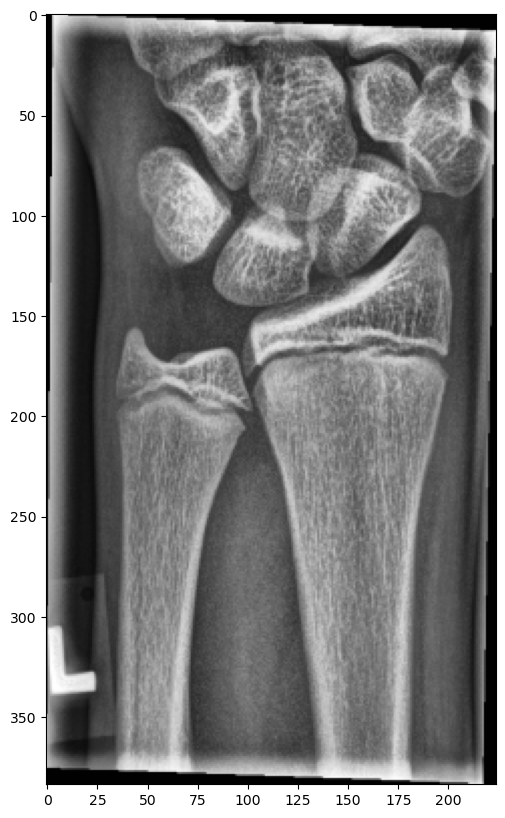

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

## Selecting objects with SAM

First, load the SAM model and predictor. Change the path below to point to the SAM checkpoint. Running on CUDA and using the default model are recommended for best results.

In [5]:
# import sys
# sys.path.append("..")
import os
from clearml import InputModel
from custom_arcitecture.classic_u_net import UNet
from segment_anything.sam_mask_decoder_head import SAMMaskDecoderHead

device = 'cpu'

model_id = 'a7364b31977e42a2a15ac511cfed358f'
cl_model = InputModel(model_id)
model = UNet.load(cl_model.get_weights(), device).eval().to(device)
print(os.getcwd())
sam = SAMMaskDecoderHead("../data/sam_vit_h_4b8939.pth", "vit_h", device, "../data/graz_sam_img_embedding.h5")

/home/ron/Documents/SemiSAM/notebooks


In [6]:
from scripts.seg_grazpedwri_dataset import LightSegGrazPedWriDataset

img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
img = torch.from_numpy(img).float().unsqueeze(0).unsqueeze(0).float() / 255
img = (img - LightSegGrazPedWriDataset.IMG_MEAN) / LightSegGrazPedWriDataset.IMG_STD
y_hat = model(img).squeeze(0)
y_hat = torch.sigmoid(y_hat)
unet_mask = y_hat.clone()
bin_unet_mask = unet_mask > 0.5

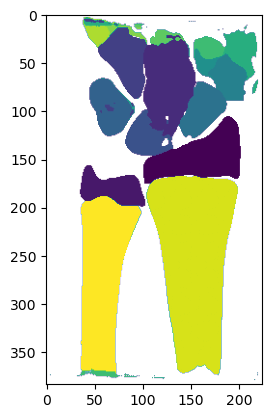

In [7]:
plt.imshow(bin_unet_mask.float().argmax(0), alpha=bin_unet_mask.any(0).float())

In [8]:
from segment_anything.utils.prompt_utils import SAMSelectingPromptExtractor

prompt_extractor = SAMSelectingPromptExtractor(unet_mask)
prompts= prompt_extractor.extract()

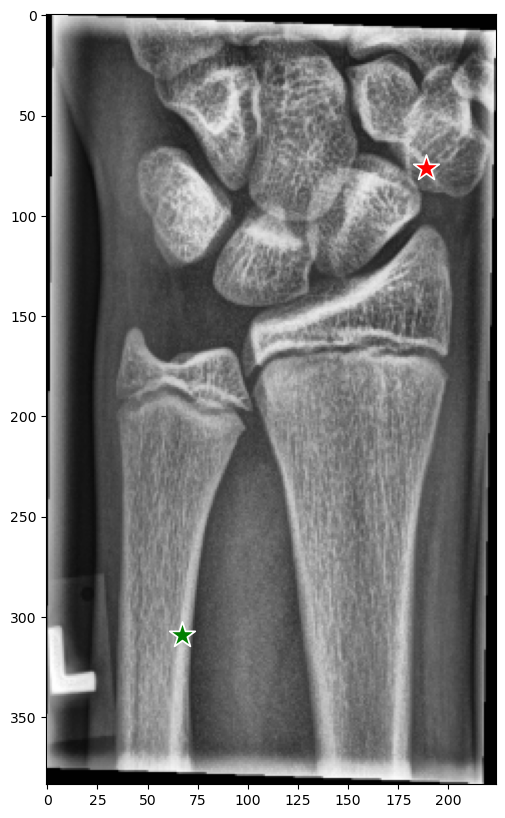

In [9]:
idx = 16
prompt = prompts[idx]
input_point = torch.cat([prompt.pos_seeds, prompt.neg_seeds]).numpy()
input_label = np.array([1] * prompt.pos_seeds.shape[0] + [0] * prompt.neg_seeds.shape[0])

plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [10]:
from torch.nn import functional as F

mask, mask_score, mask_prev_iter = sam.predict_mask(img_name, prompt, ['pos_points', 'neg_points'])
                                                             #mask_prev_iter=prompt.mask_logits)
mask = F.interpolate(mask.float(), size=unet_mask.shape[-2:], mode='nearest-exact')

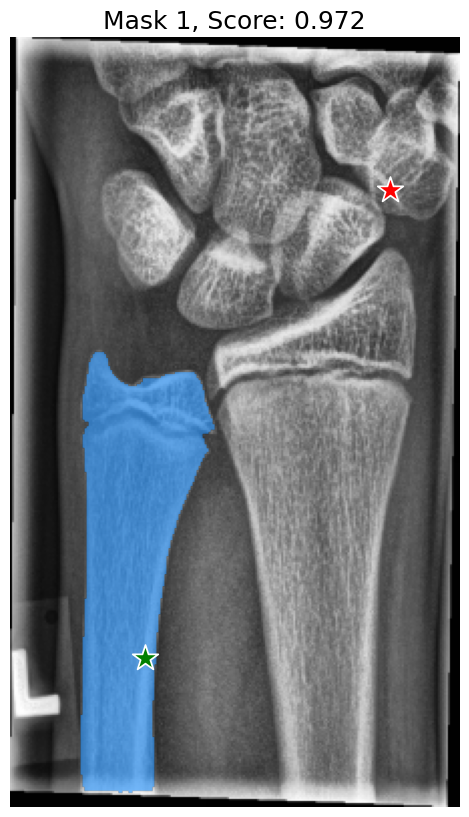

In [11]:
for i, (mask, score) in enumerate(zip(mask, mask_score)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score.item():.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  

DSC: tensor(0.8860)


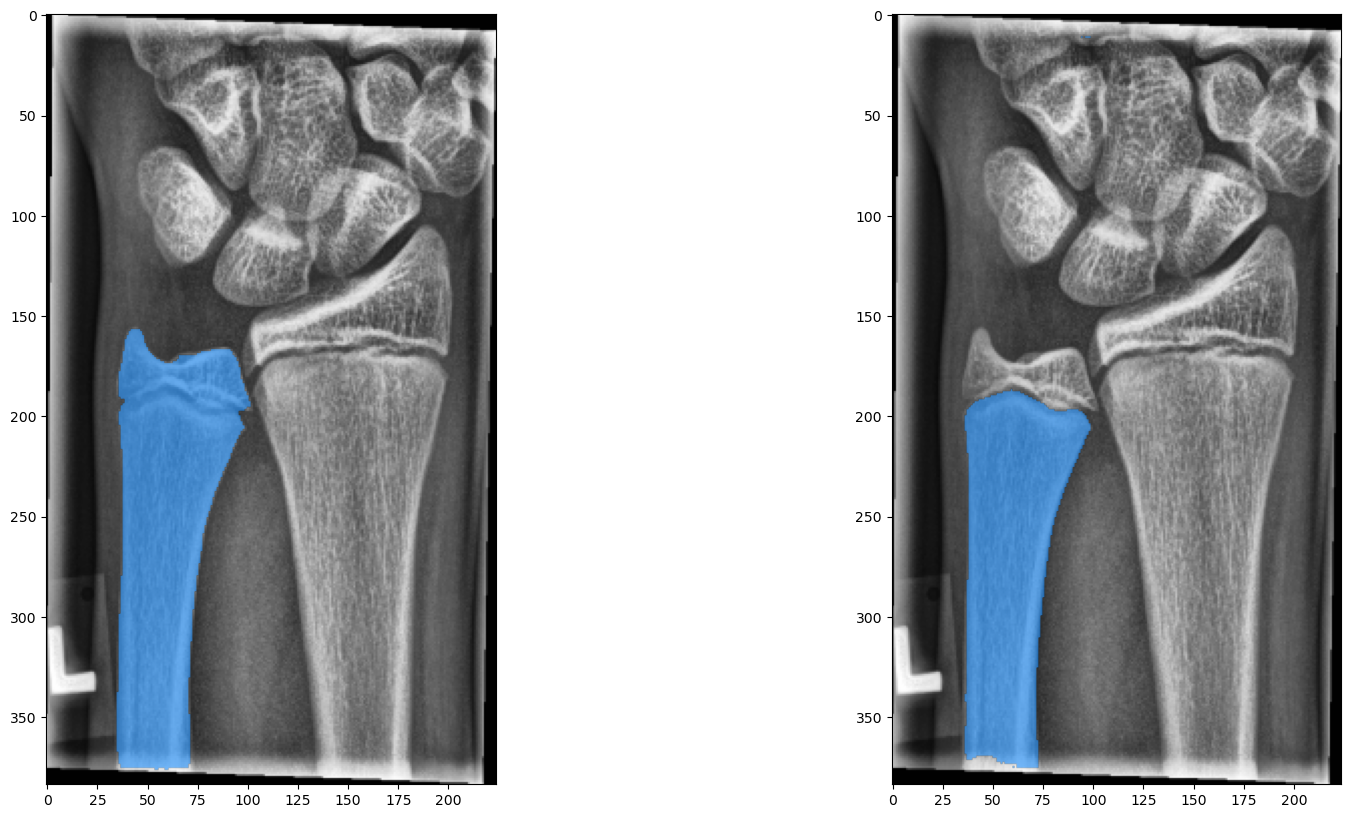

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(image)
show_mask(mask, ax[0])

ax[1].imshow(image)
show_mask(bin_unet_mask[idx].detach(), ax[1])

print('DSC:', 2*(mask * bin_unet_mask[idx].detach()).sum() / (mask.sum() + bin_unet_mask[idx].detach().sum()))